# Data Load

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Combine Datasets

In [3]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773

    # Shuffle indices of data
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    # Sizes of the train, test, val
    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size

    # Chosing indices for splitting
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    # Choosing subsets according to indices
    #Therefore we can split data randomly
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [4]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.3, patch_size = 16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob  # Probability of the masking an image
        self.patch_size = patch_size       
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]

        image = self.transform(image)

        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        _, height, width = image.shape

        # Calculate the number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        

        # An array shape like image
        # True for positions of the mask
        # False for rest of the array
        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size,  (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size,  (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[i * num_patches_w + j] = True
                    
        return masked_image, mask
    


In [6]:
dataset1 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\celeba",
)

dataset2 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\places",
)
random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

combined_dataset = ConcatDataset([custom_data1, custom_data2])


train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Example of Mask

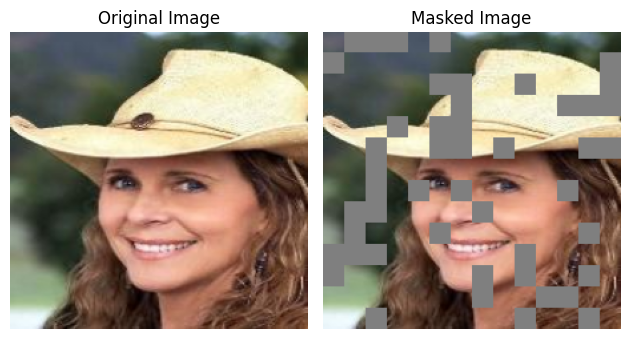

In [7]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

original_image, masked_image, mask = train_dataset[random.randint(0,2000)]  

plt.figure()

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()


# Transformer

In [8]:
from transformers import ViTModel
from transformers import ViTConfig
from tqdm import tqdm
from torchvision.models import vgg16
from pytorch_msssim import SSIM





C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class ViT_decoder(nn.Module):
    def __init__(self, pretrained_model_name="google/vit-base-patch16-224-in21k"):
        super(ViT_decoder, self).__init__()
        config = ViTConfig(image_size=224, patch_size=16, hidden_size=768, 
                           num_hidden_layers=4, num_attention_heads=4)

        self.vit = ViTModel.from_pretrained(pretrained_model_name, config= config)
        
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.encoder.parameters():
            param.requires_grad = True
        
        self.fc = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.vit.config.hidden_size)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.vit.config.hidden_size, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),  # Final layer for RGB
        )

    def forward(self, image, mask):
        output = self.vit(image).last_hidden_state
        output = output[:, 1:, :]
        output = self.fc(output)
        
        batch_size, seq_len, hidden_dim = output.shape
        patch_size = int(seq_len**0.5)
        
        output = output.permute(0, 2, 1).view(batch_size, hidden_dim, patch_size, patch_size)
        output = self.decoder(output)

        return output

## Loss

In [10]:
# class Perceptual_Loss(nn.Module):
#     def __init__(self):
#         super(Perceptual_Loss, self).__init__()
#         vgg = vgg16(pretrained=True).features
#         self.vgg_layers = nn.Sequential(*list(vgg)[:16])  # Use early layers
#         self.device = device
#         self.vgg_layers = self.vgg_layers.to(self.device)
#         for param in self.vgg_layers.parameters():
#             param.requires_grad = False
        
#     def forward(self, output, target):
#         output = output.to(self.device)
#         target = target.to(self.device)
#         output_features = self.vgg_layers(output)
#         target_features = self.vgg_layers(target)
        
#         return torch.mean((output_features - target_features)**2)

In [11]:
# class Combined_Loss(nn.Module):
#     def __init__(self):
#         super(Combined_Loss, self).__init__()
#         self.perceptual_loss = Perceptual_Loss()
#         self.ssim_loss = SSIM(data_range=1, size_average=True, channel=3)
#         self.perceptual_loss_weight = 0.8
#         self.mask_loss_weight = 0.2
#         self.device = device
        
#     def forward(self, output, target, mask):
#         output = output.to(self.device)
#         target = target.to(self.device)
        
#         mask = mask.view(batch_size, 14, 14)
#         expanded_mask = mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
#         mask = expanded_mask.unsqueeze(1).float()
#         print(mask.shape)
#         ssim_loss = 1 - self.ssim_loss(output * mask, target * mask)
#         perceptual_loss = self.perceptual_loss(output, target)
#         total_loss = self.mask_loss_weight * ssim_loss + self.perceptual_loss_weight * perceptual_loss
        
#         return total_loss
        
        

In [12]:
def plot_sample_image(original_image, masked_image, inpainted_image):   
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(unnormalize_and_convert(original_image))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(unnormalize_and_convert(masked_image))
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    ax[2].imshow(unnormalize_and_convert(inpainted_image))
    ax[2].set_title("Inpainted Image")
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## Train

In [13]:
def train_model(model, train_loader, valid_loader, num_epochs=10, device="cuda"):
    best_valid_loss = float('inf')
    patience = 3
    patience_counter = 0


    model.to(device)
    criterion = SSIM(data_range=1, size_average=True, channel=3)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


    model.train()
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs): 
        train_loss = 0.0

        for images, masked_images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}, Train"):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)
            
            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()
            # Forward pass
            outputs = model(masked_images, masks)  
            loss = 1 - criterion(outputs * expanded_mask, images * expanded_mask)  

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
        train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        aaa = True
        with torch.no_grad():
            for images, masked_images, masks in tqdm(valid_loader, desc=f"Epoch {epoch + 1},  Validation"):
                images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

                expanded_mask = masks.view(masks.size(0),14, 14)
                expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
                expanded_mask = expanded_mask.unsqueeze(1).float()
                outputs = model(masked_images, masks)
                loss = 1 - criterion(outputs* expanded_mask, images * expanded_mask)
                if(aaa == True):
                    aaa = False
                    plot_sample_image(images[0], masked_images[0], outputs[0])

                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(valid_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        val_loss_list.append(avg_val_loss)


        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "fine_tuned_vit_best_parameters.pth")
            print(f"Model improved and saved")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break
        
    results = {
        "train_loss": train_loss_list,
        "val_loss": val_loss_list
    }

    return results

model = ViT_decoder().to(device)
losses = train_model(model, train_loader, valid_loader, device=device)

Epoch 1, Train:   0%|          | 9/6639 [00:04<50:09,  2.20it/s]  

Epoch 1, Train:   1%|          | 47/6639 [00:21<49:55,  2.20it/s]


KeyboardInterrupt: 

## Load Best Transformer

In [11]:
model.load_state_dict(torch.load("fine_tuned_vit_best_parameters.pth"))


C:\Users\user\AppData\Local\Temp\ipykernel_7192\3140737136.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_vit_best_paramete

<All keys matched successfully>

## Evaluate

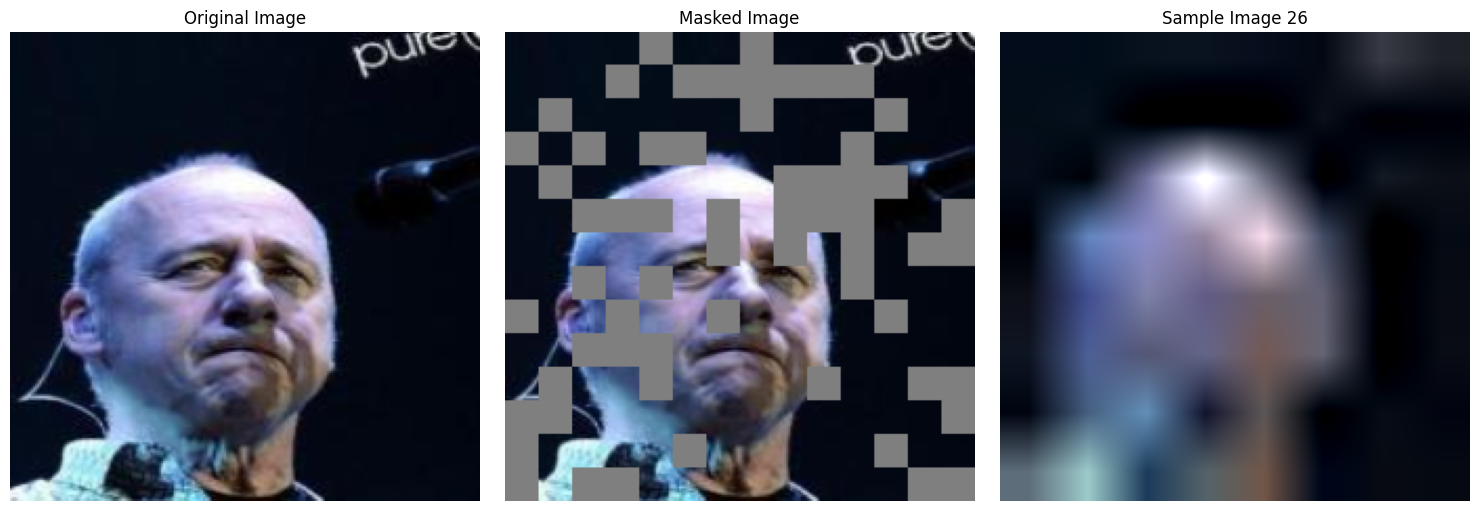

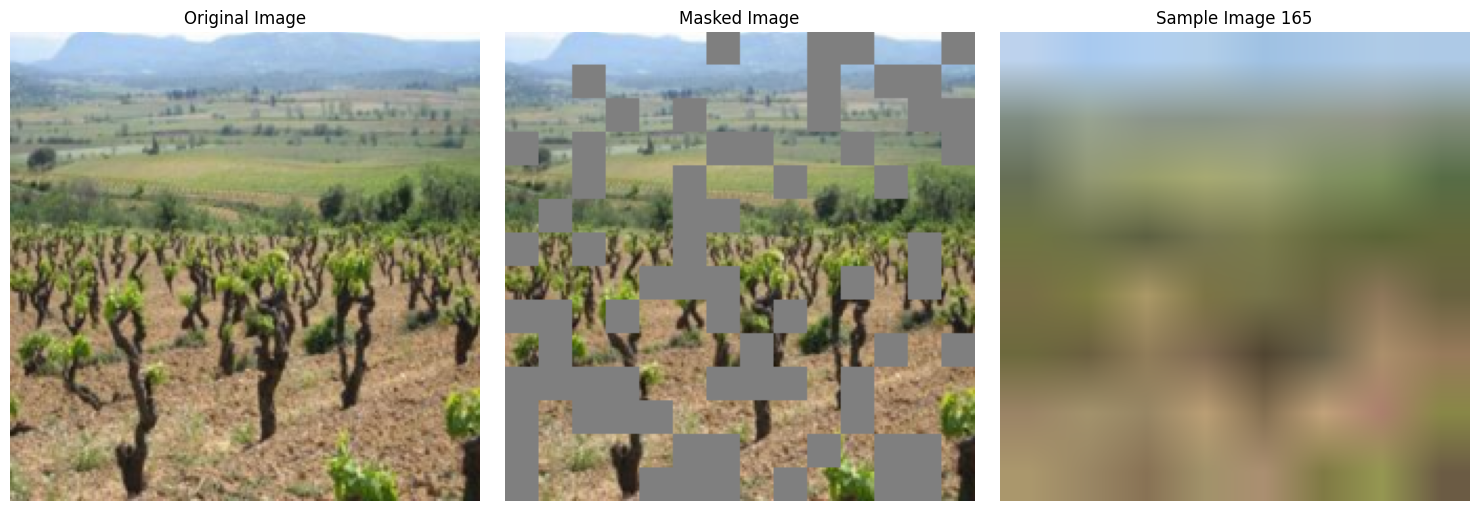

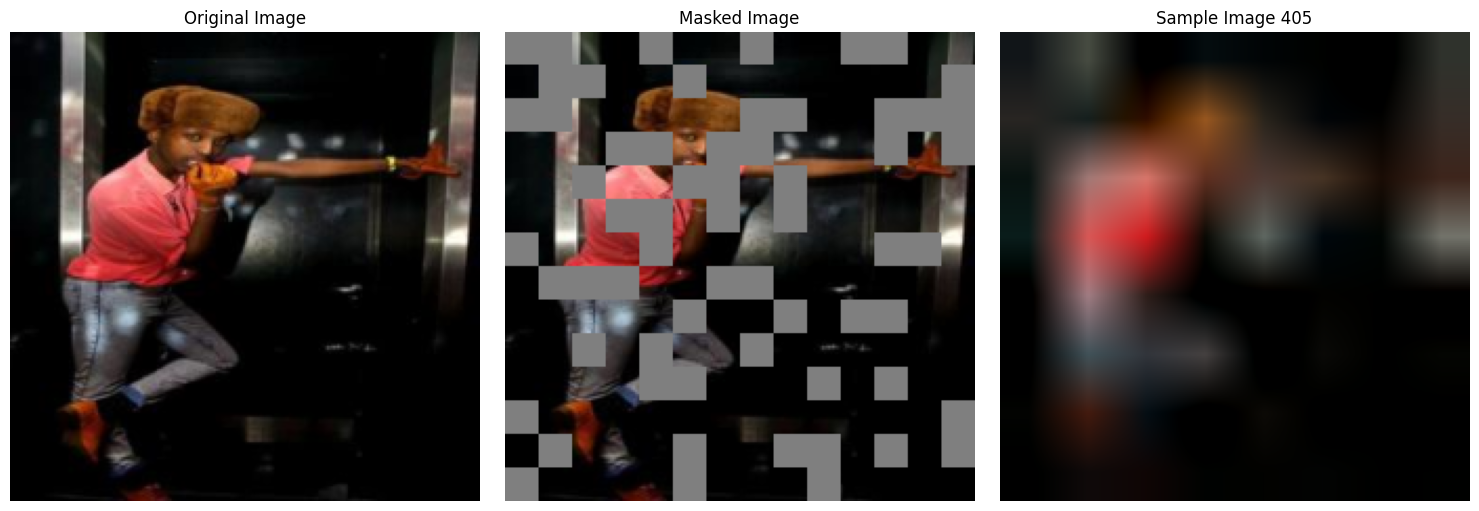

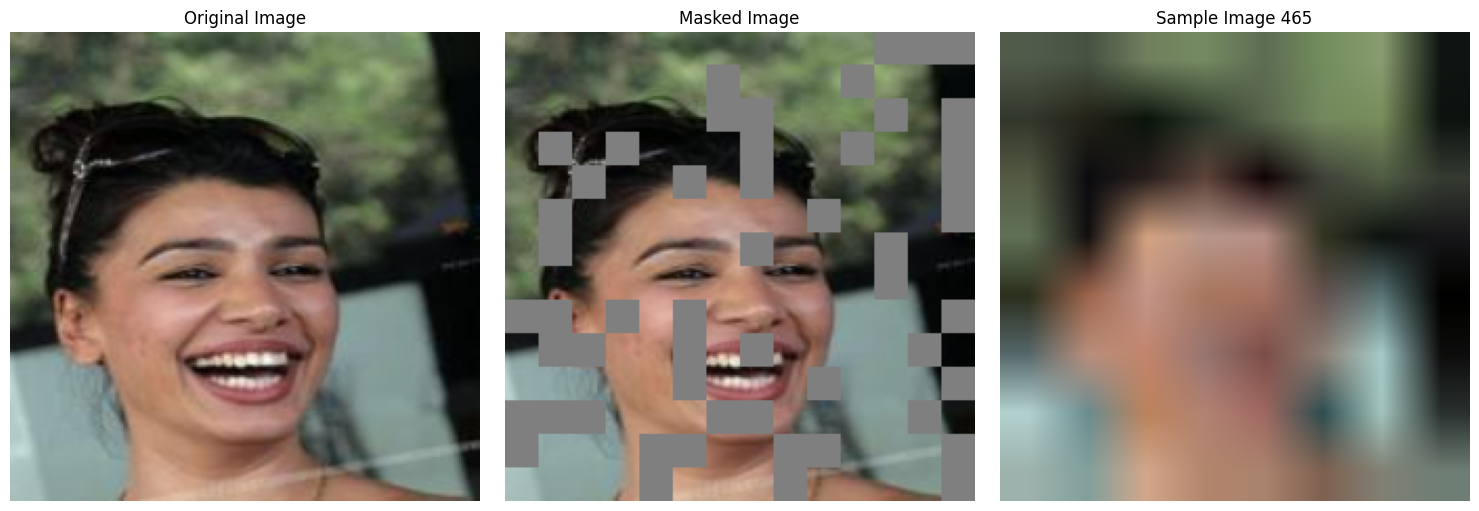

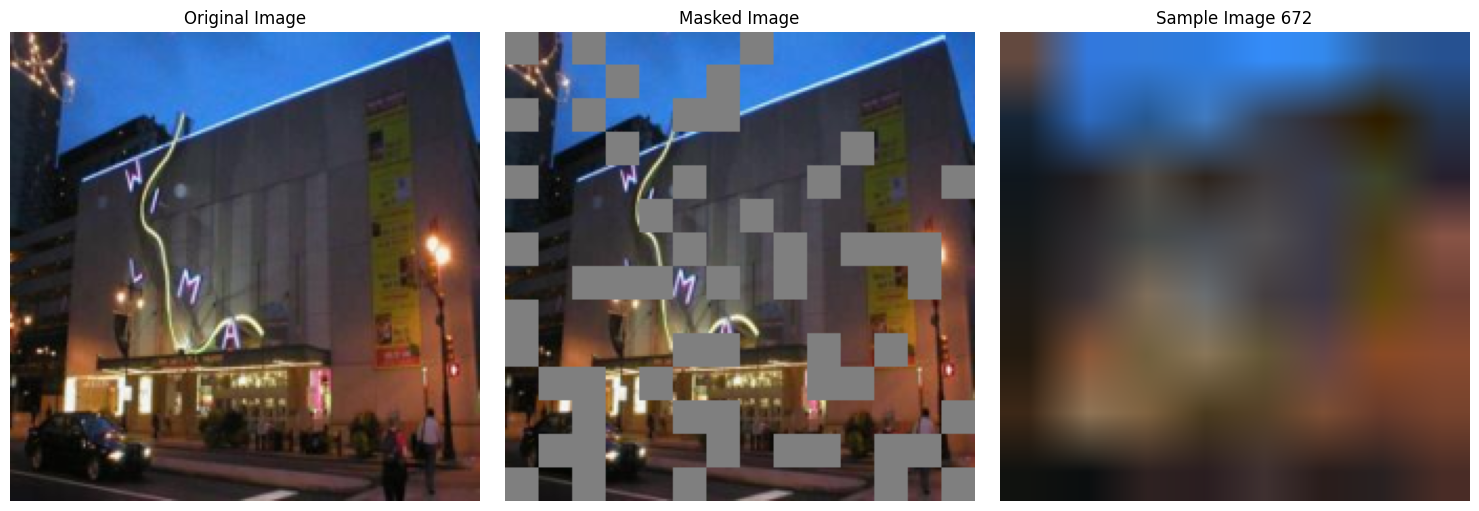

0.06860685151923133

In [ ]:
def evaluate(model, dataloader, criterion, device= "cuda", sample_size=5):
    model.eval()
    loss = 0.0
    random_indices = random.sample(range(len(dataloader)), sample_size)

    with torch.no_grad():
        for idx, (images, masked_images, masks) in enumerate(dataloader):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            outputs = model(masked_images, masks)
            loss += criterion(outputs, images).item()

            if idx in random_indices:
                inpainted_image = outputs[0].detach().cpu()
                original_image = images[0].detach().cpu()
                masked_image = masked_images[0].detach().cpu()
                plot_sample_image(idx, original_image, masked_image, inpainted_image)
    
    return loss / len(dataloader)

evaluate(model, test_loader, nn.MSELoss(), device=device, sample_size=5)

## Loss Curves

In [ ]:
def plot_losses(losses):
    train_loss = losses["train_loss"]
    val_loss = losses["val_loss"]

    plt.figure()
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses)